# Importing data from particular directory

In [4]:
import os 
HOUSING_PATH = os.path.join("datasets", "Housing")

In [5]:
import pandas as pd

def load_housing_data(filename, housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, filename)
    return pd.read_csv(csv_path)

In [6]:
#   loading test and train data
train_data = load_housing_data("train.csv")
test_data = load_housing_data('test.csv')     # loading Datasets


In [7]:
# Visualizing a part of the data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Visualising  how some selected features values are varying with SalePrice individualy

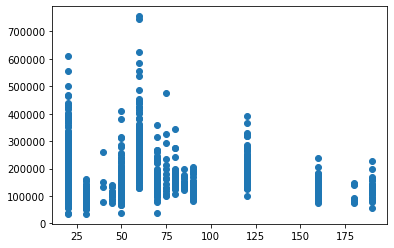

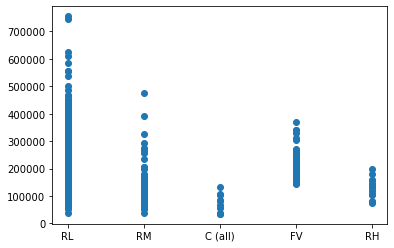

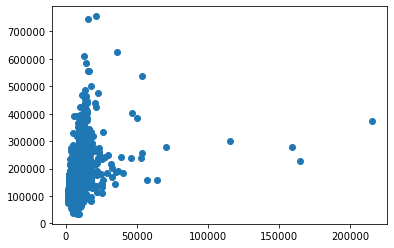

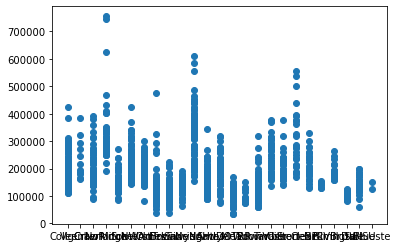

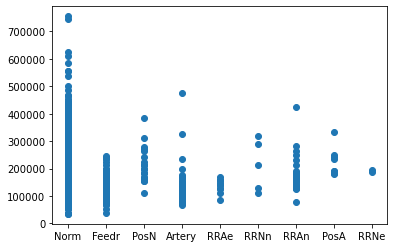

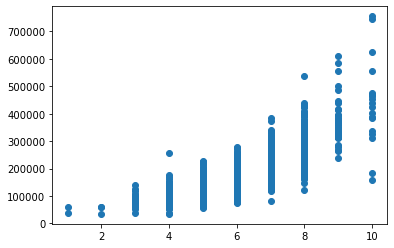

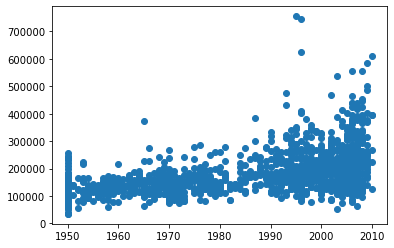

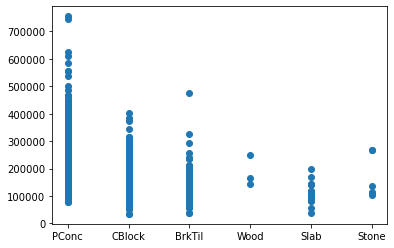

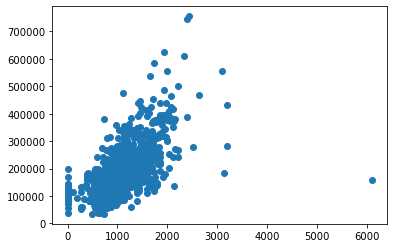

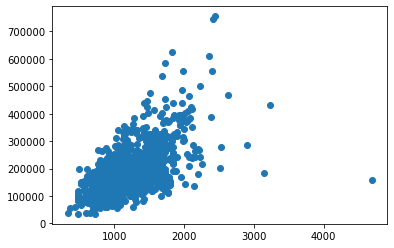

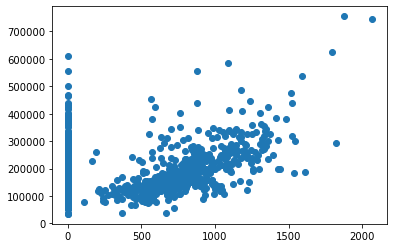

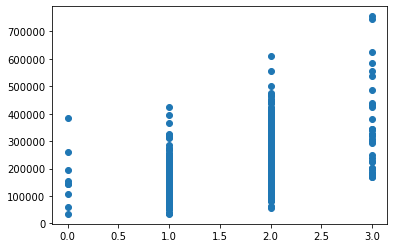

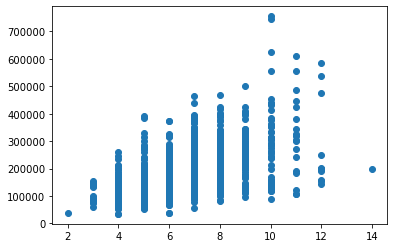

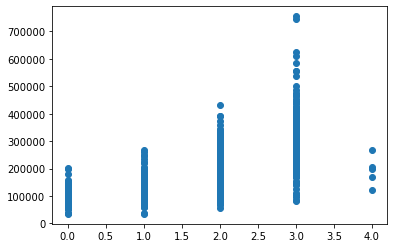

In [11]:
import matplotlib.pyplot as plt
import numpy as np

selected_features = ['MSSubClass','MSZoning','LotArea',
                     'Neighborhood','Condition1','OverallQual','YearRemodAdd',
                     'Foundation','TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath','TotRmsAbvGrd','GarageCars']

for attribute in selected_features:
    plt.scatter(train_data[attribute], train_data['SalePrice'])
    plt.show()

In [12]:
selected_features = ['MSSubClass','MSZoning','LotArea',
                     'Neighborhood','Condition1','OverallQual','YearRemodAdd',
                     'Foundation','TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath','TotRmsAbvGrd','GarageCars']

train_data_copy = train_data[selected_features].copy()
train_data_copy.info() # Creating a copy of dataframe with only selected features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSSubClass    1460 non-null   int64 
 1   MSZoning      1460 non-null   object
 2   LotArea       1460 non-null   int64 
 3   Neighborhood  1460 non-null   object
 4   Condition1    1460 non-null   object
 5   OverallQual   1460 non-null   int64 
 6   YearRemodAdd  1460 non-null   int64 
 7   Foundation    1460 non-null   object
 8   TotalBsmtSF   1460 non-null   int64 
 9   1stFlrSF      1460 non-null   int64 
 10  2ndFlrSF      1460 non-null   int64 
 11  FullBath      1460 non-null   int64 
 12  TotRmsAbvGrd  1460 non-null   int64 
 13  GarageCars    1460 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 159.8+ KB


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

# Creating a classTo fill the missing categorical feature data

class most_frequent_imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [14]:
# Specific attribute have to be returned when used in a pipeline 

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
        
    

In [17]:
from sklearn.impute import SimpleImputer # to fill numerical missing feature values
from sklearn.preprocessing import StandardScaler # to scale the data for the training
from sklearn.preprocessing import OneHotEncoder # to tranform catogerical data 
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import FeatureUnion # to merge data obtaines after transformation from different pipelines

num_pipeline = Pipeline([('selector', DataFrameSelector(['MSSubClass','LotArea','OverallQual','YearRemodAdd',
                                                         'TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath',
                                                         'TotRmsAbvGrd','GarageCars'])),
                         ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

cat_pipeline = Pipeline([('selector', DataFrameSelector(['MSZoning',
                                                         'Neighborhood','Condition1','Foundation'])),
                        ('imputer', most_frequent_imputer()),
                        ('cat_encoder', OneHotEncoder(sparse=False))])

preprocess_pipeline = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline),
                                                    ('cat_pipeline', cat_pipeline )])

X_train = preprocess_pipeline.fit_transform(train_data)

y = train_data['SalePrice']


In [18]:
X_train.shape

(1460, 55)

# Using Support Vector Regressor 





In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
svm_reg = SVR(kernel='poly', degree=2, C=1000, epsilon=1.5)
svm_pred = cross_val_predict(svm_reg, X_train, y, cv=10)

In [20]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error_ = mean_absolute_error(y, svm_pred)
mean_absolute_error_

26116.748564270005

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 10, 100, 1000], 'degree' : [2, 3], 'epsilon': [0.1, 0.5, 1.5], 'kernel':['poly', 'rbf']}
grid = GridSearchCV(SVR(), param_grid, cv=10, scoring='neg_mean_absolute_error')
grid.fit(X_train, y)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [1, 10, 100, 1000], 'degree': [2, 3],
                         'epsilon': [0.1, 0.5, 1.5],
                         'kernel': ['poly', 'rbf']},
             scoring='neg_mean_absolute_error')

In [22]:
grid.best_params_

{'C': 1000, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'}

In [23]:
grid.best_estimator_

SVR(C=1000, degree=2, kernel='poly')

In [24]:
SVR_best = grid.best_params_


In [41]:
svm_pred = cross_val_predict(grid.best_estimator_, X_train, y, cv=10)
print(mean_absolute_error(y, svm_pred))

26116.710321116752


# Using Randomforest Regressor

In [62]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1, max_features='log2')


In [63]:
forest_reg_pred_ = cross_val_predict(forest_reg, X_train, y, cv=10)

In [64]:
print(mean_absolute_error(y, forest_reg_pred_))

18555.322045272886


Using Extra Trees Regressor

In [45]:
from sklearn.ensemble import ExtraTreesRegressor
extra_tree_reg = ExtraTreesRegressor(n_jobs=-1, bootstrap=True, n_estimators=500, max_features='log2')

In [46]:
extra_tree_reg_pred = cross_val_predict(extra_tree_reg, X_train, y, cv=10)
print(mean_absolute_error(y, extra_tree_reg_pred))

18864.02402533377


# Comparing Scores of models

In [47]:
print('SVM:',mean_absolute_error(y, svm_pred))
print('RandomForest:',mean_absolute_error(y, forest_reg_pred_))
print('ExtraTrees:',mean_absolute_error(y, extra_tree_reg_pred))

SVM: 26116.710321116752
RandomForest: 18468.96198232877
ExtraTrees: 18864.02402533377


# Generating Test_data predictions using best model

In [53]:
forest_reg.fit(X_train, y)

RandomForestRegressor(max_features='log2', n_estimators=500, n_jobs=-1)

In [54]:
X_test = preprocess_pipeline.fit_transform(test_data)

In [55]:
test_pred = forest_reg.predict(X_test)

In [56]:
test_pred

array([122190.86 , 155837.   , 182097.234, ..., 164426.374, 132782.266,
       246580.126])

In [57]:
output = pd.DataFrame({'Id': test_data.Id, 'SalePrice': test_pred})

In [58]:
output.to_csv('House_Prediction_submission_2.csv', index=False)